W1= (10, 12288)
b1= (10, 1)
W2= (3, 10)
b2= (3, 1)
W3= (2, 3)
b3= (2, 1)
W4= (1, 2)
b4= (1, 1)
epoches = 0  loss = 0.1165878725802911
epoches = 500  loss = 0.05010292470027547
epoches = 1000  loss = 0.024857122691598232
epoches = 1500  loss = 0.004596168564993375
epoches = 2000  loss = 0.0020703911944966184
epoches = 2500  loss = 0.0122294769186951


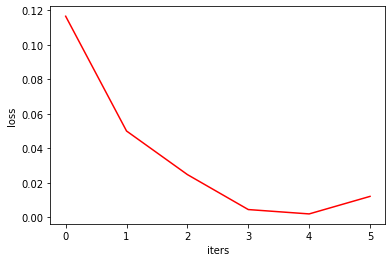

accuracy = 0.78


In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


def load_data():
    # File对象类似字典
    train_data = h5py.File('./dataset/train_catvnoncat.h5', 'r')
    test_data = h5py.File('./dataset/test_catvnoncat.h5', 'r')

    train_x = np.array(train_data['train_set_x'][:])
    train_y = np.array(train_data['train_set_y'][:])

    test_x = np.array(test_data['test_set_x'][:])
    test_y = np.array(test_data['test_set_y'][:])

    # 还原图片
    # plt.figure(figsize=(2, 2))
    # plt.imshow(train_x[10])
    # plt.show()

    # reshape数据集
    # 特征：64 * 64 * 3 = 12288
    # (209, 64, 64, 3) -> (12288, 209)
    train_x = train_x.reshape(train_x.shape[0], -1).T
    test_x = test_x.reshape(test_x.shape[0], -1).T

    # (209, ) -> (1, 209)
    train_y = train_y.reshape(1, train_y.shape[0])
    test_y = test_y.reshape(1, test_y.shape[0])
    
    return train_x, train_y, test_x, test_y


def init_params(layers, activation='sigmoid', optimizer='gd'):
    # 根据传入的数组初始化每一层的W和b
    params = {}
    layer_num = len(layers)
    if optimizer == 'momentum' or optimizer == 'rmsprop':
        # momentum中的V和RMSProp中的S
        special_cache = {}
    
    for n in range(1, layer_num):
        if activation == 'tanh':
            # Xavier初始化，使W的方差等于上一层神经元个数的倒数
            params['W'+str(n)] = np.random.randn(layers[n], layers[n-1]) * np.sqrt(1 / layers[n-1])
        elif activation == 'ReLU':
            # He初始化，ReLU激活函数的解决方案
            params['W'+str(n)] = np.random.randn(layers[n], layers[n-1]) * np.sqrt(2 / layers[n-1])
        else:
            params['W'+str(n)] = np.random.randn(layers[n], layers[n-1]) * 0.01  # 标准正态分布，*0.01将数据保持在±0.03之间
        params['b'+str(n)] = np.zeros((layers[n], 1))
        
        if optimizer == 'momentum' or optimizer == 'rmsprop':
            special_cache['dW'+str(n)] = np.zeros((layers[n], layers[n-1]))
            special_cache['db'+str(n)] = np.zeros((layers[n], 1))
    
    for n in range(1, layer_num):
        print('W'+str(n)+'=', params['W'+str(n)].shape)
        print('b'+str(n)+'=', params['b'+str(n)].shape)
    
    if optimizer == 'momentum' or optimizer == 'rmsprop':
        return params, special_cache
    else:
        return params


def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


def ReLU(Z):
    return np.maximum(0, Z)


def tanh(Z):
    return np.tanh(Z)
    
    
def sigmoid_grad(A):
    # s'(x) = s(x) * (1 - s(x))，所以此处是f(Z)而非Z
    return A * (1 - A)


def tanh_grad(A):
    return 1 - np.square(A)


def ReLU_grad(Z):
    return np.array(Z > 0)
    
    
def forward_prop(X, params, activation='sigmoid'):
    # 每一层WX+b的结果Z和激活后的结果A，用于反向传播
    # 要放入原始数据，即A0，否则反向传播会出问题
    cache = {'A0': X}  
    A = X
    layer_num = len(params) // 2  # 用/会得到浮点数
    for n in range(1, layer_num):
        # b被broadcast，（Ln, 1) -> (Ln, m), m为传入的样本数量
        Z = np.dot(params['W'+str(n)], A) + params['b'+str(n)]
        A = eval(activation+'(Z)')
        cache['Z'+str(n)] = Z
        cache['A'+str(n)] = A
    
    # 最后一层使用sigmoid
    Z = np.dot(params['W'+str(layer_num)], A) + params['b'+str(layer_num)]
    A = sigmoid(Z)
    cache['Z'+str(layer_num)] = Z
    cache['A'+str(layer_num)] = A
    
    return A, cache
    
    
def mean_square_loss(A_last, Y):
    m = Y.shape[1]
    return np.sum((A_last - Y) * (A_last - Y)) / m / 2
    

def back_prop(Y, params, cache, activation='sigmoid'):
    layer_num = len(params) // 2
    m = Y.shape[1]
    grads = {}  # 保存所有梯度
    
    # 最后一层的Z和A
    A_last = cache['A'+str(layer_num)]
    Z_last = cache['Z'+str(layer_num)]
    
    # 数组的形状
    # W(N(L), N(L-1)), 此处W是当前层左侧边权重，这样Z(L) = W(L)A(L-1)+b(L)不会矛盾
    # X/A/Z(N(L), m), b(N(L), 1)
    
    # 公式
    # (最后一层) dZ = (A(L) - y) * f'(Z(L)) /// (N(L), m), (N(L), m--广播后)
    # (非最后一层) dZ = (W(L+1).T) dZ(L+1) * f'(Z(L)) /// (N(L), N(L+1)), (N(L+1), m), (N(L), m--广播后)
    # 此处W(L+1)是指Z所在神经元右侧的W
    # dW = (1/m) * (dJ/dZ(L)) (A(L-1).T) /// (N(L), m), (m, N(L-1))
    # db = (1/m) * sum(dJ/dZ(L)) /// (N(L), m) -> (N(L), 1)
    
    # 最后一层（输出层）dJ/dZ，且使用sigmoid
    dZ = (A_last - Y) * sigmoid_grad(A_last)
    # 最后一层dJ/dW和dJ/db
    grads['dW'+str(layer_num)] = np.dot(dZ, cache['A'+str(layer_num-1)].T) / m
    # 在第二维求和（横向），保持二维
    grads['db'+str(layer_num)] = np.sum(dZ, axis=1, keepdims=True) / m
    
    for n in range(layer_num-1, 0, -1):
        if activation == 'ReLU':
            dZ = np.dot(params['W'+str(n+1)].T, dZ) * eval(activation + '_grad' + "(cache['Z'+str(n)])")
        else:
            dZ = np.dot(params['W'+str(n+1)].T, dZ) * eval(activation + '_grad' + "(cache['A'+str(n)])")
        grads['dW'+str(n)] = np.dot(dZ, cache['A'+str(n-1)].T) / m
        grads['db'+str(n)] = np.sum(dZ, axis=1, keepdims=True) / m
    
    return grads
        

def gradient_descent(grads, params, lr):
    # W = W - lr * dW，b相同
    layer_num = len(params) // 2
    for n in range(1, layer_num+1):
        params['W'+str(n)] = params['W'+str(n)] - lr * grads['dW'+str(n)]
        params['b'+str(n)] = params['b'+str(n)] - lr * grads['db'+str(n)]
        
    return params


def momentum(grads, params, V, lr, momentum=0.9):
    # V = momentum * V + dW(db)
    # W = W - lr * V
    layer_num = len(params) // 2
    for n in range(1, layer_num+1):
        V['dW'+str(n)] = V['dW'+str(n)] * momentum + grads['dW'+str(n)]
        params['W'+str(n)] = params['W'+str(n)] - lr * V['dW'+str(n)]
        
        V['db'+str(n)] = V['db'+str(n)] * momentum + grads['db'+str(n)]
        params['b'+str(n)] = params['b'+str(n)] - lr * V['db'+str(n)]
        
    return params, V


def RMSProp(grads, params, S, lr, decay=0.9, epsilon=1e-8):
    # S = decay * S + (1 - decay) * square(dW)
    # W = W - lr / sqrt(S + epsilon) * dW
    layer_num = len(params) // 2
    for n in range(1, layer_num+1):
        S['dW'+str(n)] = S['dW'+str(n)] * decay + np.square(grads['dW'+str(n)]) * (1 - decay)
        params['W'+str(n)] = params['W'+str(n)] - lr / np.sqrt(S['dW'+str(n)] + epsilon) * grads['dW'+str(n)]
        
        S['db'+str(n)] = S['db'+str(n)] * decay + np.square(grads['db'+str(n)]) * (1 - decay)
        params['b'+str(n)] = params['b'+str(n)] - lr / np.sqrt(S['db'+str(n)] + epsilon) * grads['db'+str(n)]
        
    return params, S


def dict_to_col_vector(grads_or_params, if_grads):
    # 将梯度或参数字典转为列向量
    layer_num = len(grads_or_params) // 2
    prefix = ''
    if if_grads == True:
        prefix = 'd'
    
    col_vec = np.array([[0]]) # 为了方便连接
    for n in range(1, layer_num+1):
        dW_vec = np.reshape(grads_or_params[prefix+'W'+str(n)], (-1, 1))
        db_vec = np.reshape(grads_or_params[prefix+'b'+str(n)], (-1, 1))
        col_vec = np.concatenate((col_vec, dW_vec, db_vec), axis=0)
    
    return col_vec[1:]


def col_vector_to_dict(col_vec, params_src):
    # 根据原始字典params_src的形状将col_vec复原
    layer_num = len(params_src) // 2
    reshaped = {}
    
    idx_start = 0
    idx_end = 0
    for n in range(1, layer_num+1):
        # W
        row = params_src['W'+str(n)].shape[0]
        col = params_src['W'+str(n)].shape[1]
        idx_end = idx_start + row * col
        reshaped['W'+str(n)] = col_vec[idx_start:idx_end].reshape((row, col))
        idx_start = idx_end
        # b
        row = params_src['b'+str(n)].shape[0]
        col = params_src['b'+str(n)].shape[1]
        idx_end = idx_start + row * col
        reshaped['b'+str(n)] = col_vec[idx_start:idx_end].reshape((row, col))
        idx_start = idx_end
    
    return reshaped


def L2(vec):
    return np.sqrt(np.sum(np.square(vec)))


def gradient_check(X, Y, grads, params, epsilon=1e-6, activation='sigmoid'):
    grads_vec = dict_to_col_vector(grads, True) # 使用导数定义求得的梯度值
    params_vec = dict_to_col_vector(params, False)
    grads_check = np.zeros(grads_vec.shape)
    params_num = params_vec.shape[0]
    
    # 整体的梯度检验，也可以对每个W和b进行单独检验
    for i in range(params_num):
        if i % 1000 == 0:
            print('checking gradient for parameters, checked:', i)
        # 对 参数+epsilon 求损失J
        params_vec[i][0] = params_vec[i][0] + epsilon
        A_last, _ = forward_prop(X, col_vector_to_dict(params_vec, params), activation)
        J_plus_e = mean_square_loss(A_last, Y)
        # 对 参数-epsilon 求损失J
        params_vec[i][0] = params_vec[i][0] - 2 * epsilon  # 相当于原参数减去epsilon
        A_last, _ = forward_prop(X, col_vector_to_dict(params_vec, params), activation)
        J_minus_e = mean_square_loss(A_last, Y)
        # 复原params_vec
        params_vec[i][0] = params_vec[i][0] + epsilon
        
        grads_check[i][0] = (J_plus_e - J_minus_e) / epsilon / 2
    
#         curr_grad = (J_plus_e - J_minus_e) / epsilon / 2
#         diff = abs(grads_vec[i][0] - curr_grad) / max(1, abs(grads_vec[i][0]), abs(curr_grad))
#         if diff > 1e-4:
#             print("Gradient check failed, first error index %s." % str(i))
#             print("The diff is", diff)
#             print("Your gradient: %.9f \t Numerical gradient: %.9f" % (grads_vec[i][0], curr_grad))
#             return
    diff = L2(grads_check - grads_vec) / (L2(grads_check) + L2(grads_vec))
    print("The diff is", diff)

    
def divide_data(train_x, train_y, batch_size=64):
    m = train_x.shape[1]
    # 打乱数据集
    permutation = np.random.permutation(m).tolist() # 获得一个0-m-1的随机序列
    X_shuffled = train_x[:, permutation]
    y_shuffled = train_y[:, permutation]
    mini_batches = []
    # 分批次
    batch_num = m // batch_size
    for i in range(batch_num):
        mini_batch_X = X_shuffled[:, i*batch_size : (i+1)*batch_size]
        mini_batch_y = y_shuffled[:, i*batch_size : (i+1)*batch_size]
        mini_batches.append((mini_batch_X, mini_batch_y))
    # 多余的样本
    if m % batch_size != 0:
        mini_batch_X = X_shuffled[:, (i+1)*batch_size:]
        mini_batch_y = y_shuffled[:, (i+1)*batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_y))
        
    return mini_batches
    

def train(layers, train_x, train_y, batch_size=64, grads_check=False, epoches=500, lr=0.01, activation='sigmoid', optimizer='gd'):
    # 初始化w和b
    if optimizer == 'momentum' or optimizer == 'rmsprop':
        params, special_cache = init_params(layers, activation, optimizer)
    else:
        params = init_params(layers, activation, optimizer)

    losses = []
    
    for epoch in range(epoches):
        # 应该每个epoch都对数据集进行随机打乱
        mini_batches = divide_data(train_x, train_y, batch_size)
        
        for mini_batch in mini_batches:
            mini_batch_X, mini_batch_y = mini_batch
            # 前向传播, A_last(1, 209)
            A_last, cache = forward_prop(mini_batch_X, params, activation)

            # 计算loss
            loss = mean_square_loss(A_last, mini_batch_y)
            if epoch % 500 == 0:
                print('epoches =', epoch, ' loss =', loss)
                losses.append(loss)

            # 反向传播
            grads = back_prop(mini_batch_y, params, cache, activation)
#             if grads_check and i == iters - 1:
#                 gradient_check(train_x, train_y, grads, params, activation)

            # 梯度下降更新参数
            if optimizer == 'momentum':
                params, V = momentum(grads, params, special_cache, lr)
            elif optimizer == 'rmsprop':
                params, S = RMSProp(grads, params, special_cache, lr)
            else:
                params = gradient_descent(grads, params, lr)

            # 检查梯度消失问题
#             if i > 0 and i % 2000 == 0:
#                 for n in range(1, len(layers)):
#                     # 激活值的均值和标准差
#                     print('A' + str(n) + ' mean:', np.mean(cache['A'+str(n)][:,1]), 
#                           'A' + str(n) + ' std:', np.std(cache['A'+str(n)][:,1]))
#                     # 梯度接近0的参数统计
#                     print('dW ' + str(n) + ' <e-8:', np.sum(grads['dW'+str(n)] < 1e-8), 
#                           'total:', grads['dW' + str(n)].shape[0] * grads['dW' + str(n)].shape[1])
    
    plt.plot(losses, 'r')
    plt.xlabel('iters')
    plt.ylabel('loss')
    plt.show()
    
    return params


def predict(X, Y, params, activation='sigmoid'):
    m = X.shape[1] # 样本数量
    A_last, _ = forward_prop(X, params, activation)
    result = np.zeros(A_last.shape)
    for i in range(A_last.shape[1]):
        if A_last[0][i] >= 0.5:
            result[0][i] = 1
        else:
            result[0][i] = 0
    acc = np.sum(result==Y) / m
    print('accuracy =', acc)
    
    
    
if __name__ == '__main__':
    train_x, train_y, test_x, test_y = load_data()
    # 归一化
    train_x = train_x / 255.0
    test_x = test_x / 255.0
    
    layers = [12288, 10, 3, 2, 1]
#     layers = [12288, 10, 1]
    params = train(layers, train_x, train_y, batch_size=209, epoches=3000, lr=0.0001, activation='ReLU', optimizer='rmsprop')
    predict(test_x, test_y, params, activation='ReLU')
    
    
    
    

4
